In [1]:
import numpy as np
import pandas as pd
from astropy.io import fits
from astroquery.mast import Catalogs, Observations
from astropy.table import Table, vstack
import time
import matplotlib
import matplotlib.pyplot as plt
from astropy import units as u
from astropy.coordinates import SkyCoord
import matplotlib.cm as cm
import astropy.coordinates as ac
import seaborn as sns
from tess_stars2px import tess_stars2px_function_entry as tess_stars2px
import math

catalogue_dir = 'F:/catalogues/'

ModuleNotFoundError: No module named 'tess_stars2px'

In [ ]:
data = pd.read_table(catalogue_dir + 'SDSS-DR12Q-BH.dat')
'''
Mass data borrowed from https://arxiv.org/pdf/1609.09489.pdf

   Bytes Format Units Label      Explanations
--------------------------------------------------------------------------------
   1- 10 F10.6  deg   RAdeg      Right Ascension in decimal degrees (J2000)
  12- 21 F10.6  deg   DEdeg      Declination in decimal degrees (J2000)
  24- 28 F5.3   ---   z          Redshift (visual from Paris et al. (2016))
  30- 36 F7.3   mag   Mi         Absolute Magnitude i-band from Paris et al. 
  38- 44 F7.3   ---   L5100      log10(L at 5100A in erg s^-1)  (1)
  46- 51 F6.3   ---   eL5100     error in log10(L at 5100A in erg s^-1)  (1)
  53- 59 F7.3   ---   L3000      log10(L at 3000A in erg s^-1)  (1)
  61- 65 F6.3   ---   eL3000     error in log10(L at 3000A in erg s^-1)  (1)
  68- 74 F7.3   ---   L1350      log10(L at 1350A in erg s^-1)  (1)
  76- 81 F6.3   ---   eL1350     error in log10(L at 1350A in erg s^-1)  (1)
  83- 88 F6.3   ---   MBH_MgII   log10(M_BH in units on M_SUN from MgII)  (1)
  90- 95 F6.3   ---   MBH_CIV    log10(M_BH in units on M_SUN from CIV)  (1)  
  97-102 F6.3   ---   Lbol       log10(bolometric L in erg s^-1)  (1)
 104-109 F6.3   ---   eLbol      error in log10(bolometric L in erg s^-1)  (1)
 111-116 F6.3   ---   nEdd       log10(Eddington ratio)  (1)
--------------------------------------------------------------------------------
-99.999 = no measurement.
-9.999  = no measurement or no uncertainty.

Line by line match to SDSS Quasar Data Release 12
'''

def is_number(s):
    try:
        float(s)
        return True
    except ValueError:
        return False

mass_data = [['RADeg','DECDeg','z','Mi','L5100','eL5100','L3000','eL3000','L1350','eL1350','MBH_MgII','MBH_CIV','Lbol','eLbol','nEdd']]
for row in range(len(data)-31):
    list1 = [i for i in data[row+31:row+32].to_string().split(' ') if is_number(i) is True]
    del list1[0]
    mass_data.append(list1)

In [ ]:
hdul = fits.open(catalogue_dir + 'DR12Q.fits')

data = np.array(hdul[1].data)
main_data = [[hdul[1].columns[i].name for i in range(158) if i not in [23,24,25,33,76,77,78,79,80,83,84]]]
mag_data = [['UMAG','GMAG','RMAG','IMAG','ZMAG']]

for n in range(len(data)):
    datapoint = [data[n][i] for i in range(158) if i not in [23,24,25,33,76,77,78,79,80,83,84]]
    main_data.append(datapoint)

    datapoint = data[n][78]
    mag_data.append(datapoint)

full_data = pd.DataFrame(np.hstack((np.hstack((main_data,mag_data)),mass_data)))
full_data.columns = full_data.iloc[0]
full_data = full_data.drop(labels=0)
del main_data,mag_data,mass_data
full_data.to_csv(catalogue_dir + 'full_quasar_catalogue.csv',index=False)
del full_data

In [ ]:
pd.read_csv(catalogue_dir + 'full_quasar_catalogue.csv', sep=',', header=0, squeeze=True)

full_data.replace(to_replace=-99.999,value=float('NaN')).replace(to_replace=-9.999,value=float('NaN'))
full_data.loc[float(full_data['GMAG'])<25]
full_data.to_csv(catalogue_dir + 'full_quasar_catalogue.csv')
print(len(full_data))

#df.loc[(df['column_name'] >= A) & (df['column_name'] <= B)]

In [ ]:
data = 10**pd.read_csv('final_quasar_catalogue.csv', sep=',', usecols=['MASS'], header=0, squeeze=True)

# matplotlib histogram
plt.hist(data, color = 'blue',bins = 200)

# Add labels
plt.title('Histogram of SMBH MASS')
plt.xlabel('SMBH MASS')
plt.ylabel('Objects per bin')
#plt.savefig('sect.png',dpi=1000)
print(np.mean(data))
print(np.min(data))
print(np.max(data))

In [ ]:
counter = 0
for objects in data:
    if objects < 18.5:
        counter = counter+1
        
print(counter)

In [ ]:
data = pd.read_csv('full_quasar_catalogue.csv', sep=',', usecols=['OBJ_ID'], header=0, squeeze=True)
data[0]

In [ ]:
import numpy as np
import pandas as pd
from tess_stars2px import tess_stars2px_function_entry as tess_stars2px

ralist = pd.read_csv('final_quasar_catalogue.csv', sep=',', usecols=['RA'],header=0,squeeze=True)
declist = pd.read_csv('final_quasar_catalogue.csv', sep=',', usecols=['DEC'],header=0,squeeze=True)
seclist = pd.read_csv('final_quasar_catalogue.csv', sep=',', usecols=['SECTORS'],header=0,squeeze=True)

column = np.array(['Start'])
for row in range(len(ralist)):
    if seclist[row] == 1:
        result = tess_stars2px(8675309, ralist[row], declist[row])
        sector = result[3][result[3] < 21.5]
        sectors = sector.tolist()
        if sectors[0]==-1:
            seclist[row]=0
    if row%1000 == 0:
        print(row)

np.savetxt('additional_data.csv', seclist,  fmt='%s', delimiter=',')

In [ ]:
len([i for i in range(len(seclist)) if seclist[i] == 0])

In [ ]:
obj_list = pd.read_csv('final_quasar_catalogue.csv', sep=',', usecols=['GMAG'],header=0,squeeze=True)
np.savetxt('somenums.csv', obj_list,  fmt='%s', delimiter=',')

1181


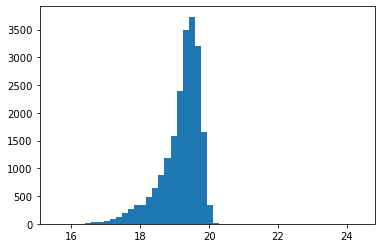

In [16]:
data = pd.read_csv('E:/catalogues/final_quasar_catalogue.csv', sep=',', usecols=['IMAG'], header=0, squeeze=True)
plt.hist(data,bins=50)

counter = 0
for i in data:
    if i < 18:
        counter += 1
print(counter)